In [ ]:
pip install "nmmo"==2.0.3

In [ ]:
import nmmo
import torch
from torch import nn
from nmmo.render.replay_helper import FileReplayHelper
import numpy as np
from math import ceil, sqrt
import random

In [ ]:
replay_helper = FileReplayHelper()

In [ ]:
# Define the amount of resources on the map
nmmo.config.Default.MAP_CENTER=32
nmmo.config.Default.PROGRESSION_SPAWN_CLUSTERS=4
nmmo.config.Default.PROGRESSION_SPAWN_UNIFORMS=8

# Define the basic things
nmmo.config.Default.TERRAIN_WATER = 0.1
nmmo.config.Default.TERRAIN_GRASS = 0.7
nmmo.config.Default.TERRAIN_FOILAGE = 0.4

# Remove the death fog
nmmo.config.Default.PLAYER_DEATH_FOG_FINAL_SIZE = 0
nmmo.config.Default.PLAYER_DEATH_FOG_SPEED = 0

In [ ]:
env = nmmo.Env()
env.config.PLAYER_N = 64
env.config.NPC_N = 0

player_N = env.config.PLAYER_N

In [ ]:
# Provide tile and entity observations to receive neural net input
def get_input(tile, entity):
  return torch.tensor(np.concatenate((tile.reshape(-1), entity.reshape(-1)), axis = None)).float()

In [ ]:
obs = env.reset()

In [ ]:
env.realm.record_replay(replay_helper)

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  # Input layer to first hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(hidden_size2, output_size)   # Second hidden layer to output layer
        self.tanh = nn.Tanh()  # Tanh activation function

    def forward(self, x):
        x = self.tanh(self.fc1(x))  # Pass through first hidden layer with tanh activation
        x = self.tanh(self.fc2(x))  # Pass through second hidden layer with tanh activation
        x = self.tanh(self.fc3(x))  # Pass through output layer with tanh activation
        return x

In [ ]:
# Define the model
input_size = 3775
hidden_size1 = 225
hidden_size2 = 75
output_size = 5
output_size_attack = player_N+1

# Random weights with a FF network
model_dict = {i+1: (FeedForwardNN(input_size, hidden_size1, hidden_size2, output_size), FeedForwardNN(input_size, hidden_size1, hidden_size2, output_size_attack))  for i in range(player_N)} # Dictionary of random models for each agent

In [ ]:
# Functions for saving and loading neural network weights
def save_state(models_dictionary, save_path):
  for i in models_dictionary:
    torch.save(model_dict[i][0].state_dict(), f"{save_path}/agent_move_{i}")
    torch.save(model_dict[i][1].state_dict(), f"{save_path}/agent_attack_{i}")

def load_state(models_dictionary, load_path):
  for i in models_dictionary:
    model_dict[i][0].load_state_dict(torch.load(f"{load_path}/agent_move_{i}"))
    model_dict[i][1].load_state_dict(torch.load(f"{load_path}/agent_attack_{i}"))

In [ ]:
# Forward pass with a feed forward NN
action_list = []
action_list_attack = []

for i in range(env.config.PLAYER_N):
  if (env.realm.players.corporeal[1].alive):
    # Get the observations
    input = get_input(obs[i+1]['Tile'], obs[i+1]['Entity'])
    # Get move actions
    output = model_dict[i+1][0](input)
    # Get attack actions (target, since agents only do melee combat)
    output_attack = model_dict[i+1][1](input)
    action_list.append(output.argmax())
    action_list_attack.append(output_attack.argmax())

actions = {}
for i in range(env.config.PLAYER_N):
  actions[i+1] = {"Move":{"Direction":1}, "Attack":{"Style":1,"Target":int(action_list_attack[i])}}

In [ ]:
#Checking for how long each of the agents has travelled during the course of its life
def get_distance_travelled(entities, spawn_positions, agent_number):
  x_2, y_2 = entities[agent_number].pos #current position coordinates
  x_1, y_1 = spawn_positions[agent_number] #spawn position coordinates

  dist_squared = (x_2 - x_1)**2 + (y_2 - y_1)**2
  if (dist_squared) != 0:
    return sqrt(dist_squared)
  else:
    return 0

#EXAMPLE: get_distance_travelled(env.realm.players.entities, env.game_state.spawn_pos, 3)

In [ ]:
# TODO: Make this more efficient - spatial locality
def mutate(player_num, alpha=0.01):
  # mutate movement network
  for param in model_dict[player_num][0].parameters():
    with torch.no_grad():
      param.add_(torch.randn(param.size()) * alpha)
  # mutate attack network
  for param in model_dict[player_num][1].parameters():
    with torch.no_grad():
      param.add_(torch.randn(param.size()) * alpha)

In [ ]:
replay_helper.reset()

In [ ]:
def fitness():
  fitness_dict = {}

  # Calculate distance travelled for each agent
  for i in range(player_N):
    if i+1 in env.realm.players.entities:
      fitness_dict[i+1] = get_distance_travelled(env.realm.players.entities, env.game_state.spawn_pos, i+1)

  # Get index of max value (the best agent number)
  best_agent = max(fitness_dict, key=fitness_dict.get)

  return fitness_dict

In [ ]:
life_durations = {i+1: 0 for i in range(env.config.PLAYER_N)}

In [ ]:
# Getting spawn positions
spawn_positions = []
for i in range(player_N):
  spawn_positions.append(env.realm.players.entities[i+1].spawn_pos)

In [ ]:
#Select top beta % of agents that travelled the longest distances/lived the longest/both and then from those randomly pick the parent
def pick_best():
  beta = ceil(0.3*env.config.PLAYER_N)

  # Get beta top percent of both
  my_keys_long_runners = sorted(fitness(), key=fitness().get, reverse=True)[:beta]
  my_keys_long_livers = sorted(life_durations, key=life_durations.get, reverse=True)[:beta]
  bestest = list(set(my_keys_long_runners).intersection(my_keys_long_livers))

  # Pick the best from the intersetction of the longest living agents and furthest walking agents. If that is empty then pick one from the longest living agents.
  if bestest:
    parent = random.choice(bestest)
  else:
    parent = random.choice(my_keys_long_livers)


  return parent

#pick_best()


In [ ]:
# Combining two neural networks
def multi_reproduction(child, parent1, parent2):
  for layer in model_dict[child][0].state_dict().keys():
    l = random.randint(1, 2)
    # randomly pick whose parents layer the current layer should be
    match l:
      case 1:
        model_dict[child][0].state_dict()[layer] = model_dict[parent1][0].state_dict()[layer]
        break
      case 2:
        model_dict[child][0].state_dict()[layer] = model_dict[parent2][0].state_dict()[layer]
        break
  return

In [ ]:
def calculate_avg_lifetime():
  sum = 0
  for i in range(player_N):
    if i+1 in env.realm.players.entities and i+1 in obs:
      sum += env.realm.players.entities[i+1].__dict__['time_alive'].val
  sum = sum/player_N
  return sum

In [ ]:
# Setting up a visited tiles dictionary
visited_tiles = {i+1: [] for i in range(player_N)}

# Setting up the average lifetime dictionary
avg_lifetime = {}

# Set up a list of all visited tiles by all agents
all_visited = []

# Set up max lifetime

max_lifetime = 0
max_lifetime_dict = {}

In [ ]:
!unzip 64.zip

In [ ]:
load_state(model_dict, "64")

In [ ]:
steps = 100

for i in range(steps):
  # Uncomment for saving replays
  print(i)
  #if i%1000 == 0:
  #  replay_file = f"/content/replay1"
  #  replay_helper.save(replay_file, compress=True)

  current_oldest = life_durations[max(life_durations, key=life_durations.get)]
  if current_oldest > max_lifetime:
    max_lifetime = current_oldest

  # Assign the top-all-time age record to the current tick
  max_lifetime_dict[i] = max_lifetime

  if i%10000 == 0:
    obs = env.reset()

  elif i%1000 == 0:
    save_state(model_dict, f"weights_128_dynamic")
    !tar chvfz weights_128_dynamic.tar.gz weights_128_dynamic/*

  #If the number of agents alive doesn't correspond to PLAYER_N, respawn
  if env.num_agents != player_N:
    for i in range(player_N):
      if i+1 not in env.realm.players.entities:

        # Spawn individual at a random location
        env.realm.players.cull()
        x, y = random.choice(spawn_positions)
        env.realm.players.spawn_individual(x, y, i+1)

        '''
        # Pick the parents
        parent = pick_best()
        parent2 = 0
        while(parent2 == parent or parent2 == 0):
          parent2 = pick_best()
        '''

        parent = pick_best()

        # Upon the "birth" of a new agent, reset the life duration and visited tiles
        life_durations[i+1] = 0
        visited_tiles[i+1] = []

        # Multi-agent based reproduction
        #multi_reproduction(i+1, parent, parent2)
        model_dict[i+1] = model_dict[parent]

        # Choosing the mutation 'intensity'
        # TODO: Try continuos mutation rate

        if life_durations[parent] > 60:
          mutate(i+1, 0.01)
        elif life_durations[parent] > 30:
          mutate(i+1, 0.05)
        else:
          mutate(i+1,0.1)

        #mutate(i+1, 0.02)
        # TODO: third mutation alternative - multiple parents

  # Calculate average lifetime of all agents every 20 steps
  avg_lifetime[i] = calculate_avg_lifetime()

  # The main loop
  for i in range(env.config.PLAYER_N):

    # Check if agents are alive, and if someone dies ignore their action
    if i+1 in env.realm.players.entities and i+1 in obs:
      #Increment life duration of each agent
      life_durations[i+1] += 1

      #Put the current pos of an agent into the visited positions dictionary
      visited_tiles[i+1].append(env.realm.players.entities[i+1].pos)


      all_visited.append(env.realm.players.entities[i+1].pos)

      input = get_input(obs[i+1]['Tile'], obs[i+1]['Entity'])
      output = model_dict[i+1][0](input)
      output_attack = model_dict[i+1][1](input)

      ### action_list.append(output)
      actions[i+1] = {"Move":{"Direction":1}, "Attack":{"Style":1,"Target":int(output_attack.argmax())}, "Use":{"InventoryItem":0}}

    else: actions[i+1] = {}

  # Run a step
  obs, rewards, dones, infos = env.step(actions)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
!tar chvfz weights_128_02_05_25.tar.gz weights/*

weights/agent_attack_1
weights/agent_attack_10
weights/agent_attack_100
weights/agent_attack_101
weights/agent_attack_102
weights/agent_attack_103
weights/agent_attack_104
weights/agent_attack_105
weights/agent_attack_106
weights/agent_attack_107
weights/agent_attack_108
weights/agent_attack_109
weights/agent_attack_11
weights/agent_attack_110
weights/agent_attack_111
weights/agent_attack_112
weights/agent_attack_113
weights/agent_attack_114
weights/agent_attack_115
weights/agent_attack_116
weights/agent_attack_117
weights/agent_attack_118
weights/agent_attack_119
weights/agent_attack_12
weights/agent_attack_120
weights/agent_attack_121
weights/agent_attack_122
weights/agent_attack_123
weights/agent_attack_124
weights/agent_attack_125
weights/agent_attack_126
weights/agent_attack_127
weights/agent_attack_128
weights/agent_attack_13
weights/agent_attack_14
weights/agent_attack_15
weights/agent_attack_16
weights/agent_attack_17
weights/agent_attack_18
weights/agent_attack_19
weights/agen

In [ ]:
# Save replay file and the weights

#replay_file = f"/content/replay1"
replay_helper.save("no_brain22", compress=False)
#save_state(model_dict, f"weights")

In [ ]:
!tar chvfz weights_128.tar.gz weights/*

weights/agent_attack_1
weights/agent_attack_10
weights/agent_attack_100
weights/agent_attack_101
weights/agent_attack_102
weights/agent_attack_103
weights/agent_attack_104
weights/agent_attack_105
weights/agent_attack_106
weights/agent_attack_107
weights/agent_attack_108
weights/agent_attack_109
weights/agent_attack_11
weights/agent_attack_110
weights/agent_attack_111
weights/agent_attack_112
weights/agent_attack_113
weights/agent_attack_114
weights/agent_attack_115
weights/agent_attack_116
weights/agent_attack_117
weights/agent_attack_118
weights/agent_attack_119
weights/agent_attack_12
weights/agent_attack_120
weights/agent_attack_121
weights/agent_attack_122
weights/agent_attack_123
weights/agent_attack_124
weights/agent_attack_125
weights/agent_attack_126
weights/agent_attack_127
weights/agent_attack_128
weights/agent_attack_13
weights/agent_attack_14
weights/agent_attack_15
weights/agent_attack_16
weights/agent_attack_17
weights/agent_attack_18
weights/agent_attack_19
weights/agen

## Data viz

In [ ]:
# Fitness functions
'''
def movement_fitness(movement_dict):
  1. for every 50 ticks, check the average number of tiles visited by currently alive agents
  2. plot the 50-tick against the average tiles visited

def life_fitness(life_dict)
  1. for every 50 ticks, check the average lifetime of currently alive agents
  2. plot the 50-tick against the average lifetime

def combined_fitness()
  1. for every 50 ticks check both the average lifetime and tiles visited
  2. normalize the score for both and combine it
  3. plot it
'''

In [ ]:
visited_tiles

{1: [(111, 16),
  (111, 17),
  (112, 17),
  (113, 17),
  (114, 17),
  (115, 17),
  (114, 17),
  (113, 17),
  (114, 17),
  (115, 17),
  (115, 17),
  (115, 17),
  (115, 17),
  (116, 17),
  (117, 17),
  (118, 17),
  (119, 17),
  (120, 17),
  (119, 17),
  (120, 17),
  (119, 17),
  (120, 17),
  (119, 17),
  (120, 17)],
 2: [(144, 101),
  (144, 100),
  (144, 100),
  (144, 100),
  (144, 101),
  (144, 102),
  (144, 103),
  (144, 104),
  (144, 104),
  (144, 104),
  (144, 104),
  (144, 104),
  (144, 104),
  (144, 105),
  (144, 106),
  (144, 107),
  (144, 108),
  (144, 109),
  (144, 109),
  (144, 109),
  (144, 109)],
 3: [(47, 144),
  (48, 144),
  (49, 144),
  (49, 144),
  (49, 144),
  (49, 144),
  (49, 144),
  (50, 144),
  (50, 144),
  (50, 144),
  (51, 144),
  (52, 144),
  (52, 144),
  (53, 144),
  (54, 144),
  (54, 143),
  (54, 142),
  (54, 141),
  (54, 140),
  (54, 141),
  (54, 141)],
 4: [(85, 16),
  (85, 17),
  (85, 16),
  (84, 16),
  (83, 16),
  (82, 16),
  (81, 16),
  (80, 16),
  (81, 16)

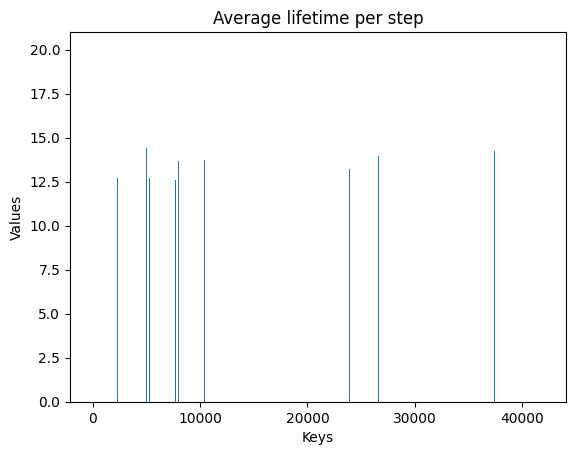

In [ ]:
import matplotlib.pyplot as plt

# Extracting keys and values
keys = list(avg_lifetime.keys())
values = list(avg_lifetime.values())

# Plotting
plt.bar(keys, values)
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Average lifetime per step')
plt.show()

In [ ]:
# This is how to get food level
env.realm.players.entities[1].__dict__['food'].val
env.realm.players.entities[1].__dict__['time_alive'].val

8

In [ ]:
env.realm.players.entities[1].__dict__['status'].__dict__['freeze'].val

0

In [ ]:
env.realm.players.entities[1].State.__dict__

{'attr_name_to_col': {'id': 0,
  'npc_type': 1,
  'row': 2,
  'col': 3,
  'damage': 4,
  'time_alive': 5,
  'freeze': 6,
  'item_level': 7,
  'attacker_id': 8,
  'latest_combat_tick': 9,
  'message': 10,
  'gold': 11,
  'health': 12,
  'food': 13,
  'water': 14,
  'melee_level': 15,
  'melee_exp': 16,
  'range_level': 17,
  'range_exp': 18,
  'mage_level': 19,
  'mage_exp': 20,
  'fishing_level': 21,
  'fishing_exp': 22,
  'herbalism_level': 23,
  'herbalism_exp': 24,
  'prospecting_level': 25,
  'prospecting_exp': 26,
  'carving_level': 27,
  'carving_exp': 28,
  'alchemy_level': 29,
  'alchemy_exp': 30},
 'num_attributes': 31,
 'table': <function nmmo.datastore.serialized.SerializedState.subclass.<locals>.Subclass.<lambda>(ds)>}

In [ ]:
import numpy as np

# Original dataset
data = np.array([3, 1.2, 6.7, 8.8, 11, 8, 23, 5, 5.8, 9])

# Number of bootstrap samples
n_bootstrap_samples = 10000

# Container for bootstrap means
bootstrap_means = np.empty(n_bootstrap_samples)

# Bootstrapping
np.random.seed(42)  # For reproducibility
for i in range(n_bootstrap_samples):
    # Create a bootstrap sample
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    # Calculate the mean of the bootstrap sample
    bootstrap_means[i] = np.mean(bootstrap_sample)

# Calculate the 95% confidence interval
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

(lower_bound, upper_bound)


(5.18, 12.0)

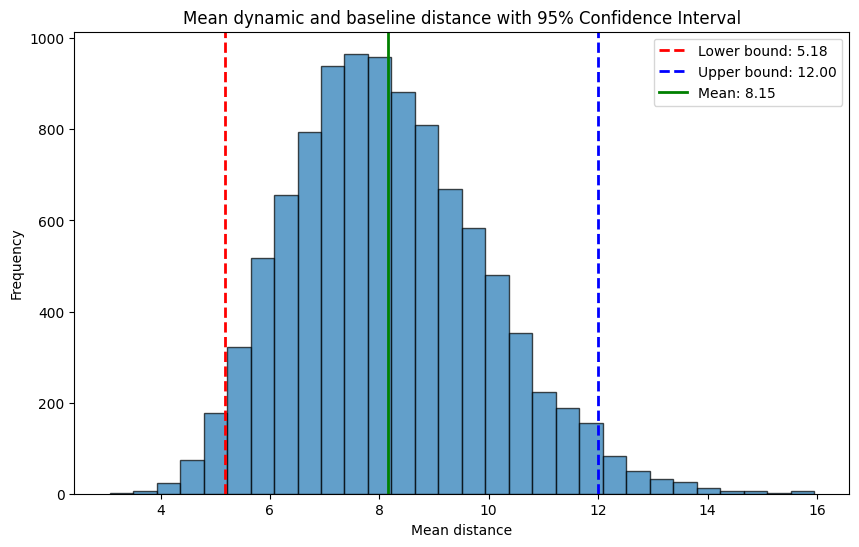

In [ ]:
import matplotlib.pyplot as plt

# Plotting the bootstrap means
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f'Lower bound: {lower_bound:.2f}')
plt.axvline(upper_bound, color='blue', linestyle='dashed', linewidth=2, label=f'Upper bound: {upper_bound:.2f}')
plt.axvline(np.mean(data), color='green', linestyle='solid', linewidth=2, label=f'Mean: {np.mean(data):.2f}')
plt.title('Mean dynamic and baseline distance with 95% Confidence Interval')
plt.xlabel('Mean distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()
